Load Dataset

In [1]:
from datasets.AGCLoader import ArgiculturalDataset
from torch.utils.data import DataLoader

c:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = ArgiculturalDataset(split='train' , image_size= 352 , mask='text_and_blur3_highlight01')
dataset = DataLoader(data, batch_size= 64, shuffle= True)

In [3]:
import matplotlib.pyplot as plt
def visualize_images(tensor_images):
    tensor_images = tensor_images.cpu()
    
    np_images = tensor_images.numpy().transpose((0, 2, 3, 1))
    
    fig, axs = plt.subplots(1, tensor_images.size(0), figsize=(15, 3))
    
    for i, ax in enumerate(axs):
        # Display the image
        ax.imshow(np_images[i])
        ax.axis('off') 
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


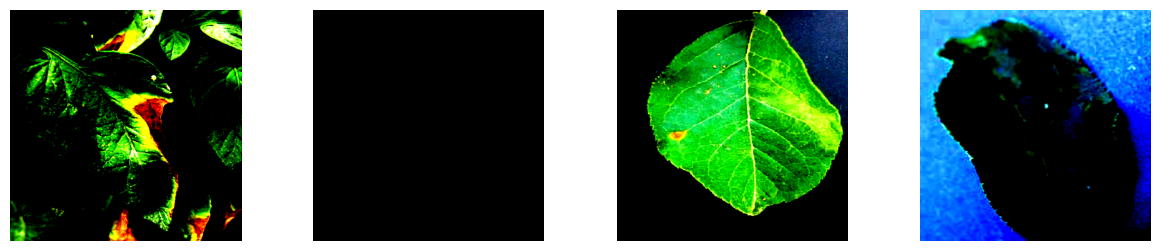

In [5]:
first = next(iter(dataset))
visualize_images(first[0][0][0:4])

In [6]:
first[0][1][0:4]

('NormalLeaf', 'CedarAppleRust', 'CedarAppleRust', 'AppleScab')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


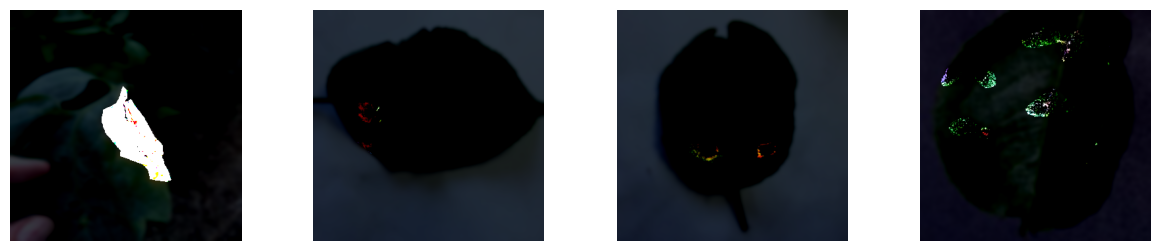

In [7]:
visualize_images(first[0][2][0:4])

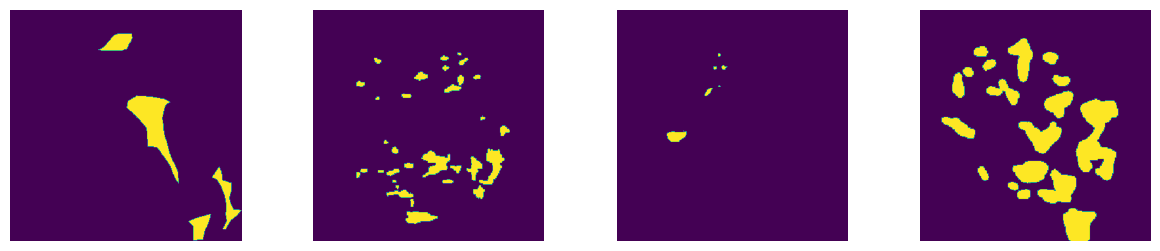

In [8]:
visualize_images(first[1][0][0:4])

In [9]:
from datasets.coco_wrapper import COCOWrapper

In [10]:
coco = COCOWrapper(split='train' , fold=0, image_size=352, aug= '1new', mask='text_and_blur3_highlight01')
cocodataset = DataLoader(coco, batch_size= 64 , shuffle= True)
first_coco = next(iter(cocodataset))

Load Model

In [11]:
from models.clipseg import CLIPDensePredT
import torch

In [12]:
model = CLIPDensePredT(version='ViT-B/16',extract_layers= (3,7,9), reduce_dim=64, fix_shift=False , prompt='shuffle+').cuda()

Load Valdiate

In [27]:
from torch.optim import AdamW
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
from general_utils import TrainingLogger, get_attribute, filter_args, log, training_config_from_cli_args
import math

In [19]:
lr = 0.0001
loss_fn = binary_cross_entropy_with_logits
autocast_fn = autocast
scaler = GradScaler()

In [20]:
def cosine_warmup_lr(i, warmup=10, max_iter=90):
    """ Cosine LR with Warmup """
    if i < warmup:
        return (i+1)/(warmup+1)
    else:
        return 0.5 + 0.5*math.cos(math.pi*(((i-warmup)/(max_iter- warmup))))


def validate(model, dataset,):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False)

    metric_class, use_metric = None, None
    loss_fn = binary_cross_entropy_with_logits

    model.eval()
    model.cuda()

    if metric_class is not None:
        metric = get_attribute(metric_class)()

    with torch.no_grad():

        i, losses = 0, []
        for data_x, data_y in data_loader:

            data_x = [x.cuda() if isinstance(x, torch.Tensor) else x for x in data_x]
            data_y = [x.cuda() if isinstance(x, torch.Tensor) else x for x in data_y]

            prompts = model.sample_prompts(data_x[1], prompt_list=('a photo of a {}',))
            pred, visual_q, _, _  = model(data_x[0], prompts, return_features=True)

            if metric_class is not None:
                metric.add([pred], data_y)

            # pred = model(data_x[0], prompts)
            # loss = loss_fn(pred[0], data_y[0])
            loss = loss_fn(pred, data_y[0])
            losses += [float(loss)]

            i += 1
            
    if use_metric is None:
        return np.mean(losses), {}, False
    else:
        metric_scores = {m: s for m, s in zip(metric.names(), metric.value())} if metric is not None else {}
        return np.mean(losses), metric_scores, True

In [21]:
opt = AdamW(model.parameters(), lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 2000,0.0001)

Training

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
!set CUDA_LAUNCH_BLOCKING=1

In [34]:
i ,error_batch  = 0,...
for data_x, data_y in dataset:
    with autocast_fn():
        prompts = model.sample_prompts(first[0][1])
        text_cond =  model.compute_conditional(prompts)
        visual_s_cond, _, _ = model.visual_forward(first[0][2].cuda())
    text_weights = torch.distributions.Uniform(0.0, 1.0).sample((64,))[:, None]
    text_weights = text_weights.cuda()
    cond = text_cond * text_weights + visual_s_cond * (1 - text_weights)

    with autocast_fn():
        visual_q = None

        pred, visual_q, _, _  = model(first[0][0].cuda(), cond, return_features=True)

        loss = loss_fn(pred, first[1][0].cuda())

        extra_loss = 0
        loss += extra_loss
    print(i, '--->' , loss)
    if loss < 0: 
        error_batch = [data_x,data_y]
        break
    opt.zero_grad()

    if scaler is None:
        loss.backward()
        opt.step()

    lr_scheduler.step()

    

    i+=1

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
